# RoPE - Rotary Positional Embeddings 
RoPE encodes position by rotating query and key vectors with sinusoidal angles. This rotation increases proportionally with token index, giving attention a sense of relative position while preserving linearity. It replaces absolute positional embeddings and improves extrapolation to longer sequences

In [1]:
import torch as torch 
import torch.nn as nn

Computing raw angular frequencies 

In [7]:
# setting params 
dim = 8 
seqlen = 10 
base = 10000
factor = 2.0

In [8]:
# theta 
freqs = 1.0 / (base ** (torch.arange(0, dim, 2) / dim))
freqs

tensor([1.0000, 0.1000, 0.0100, 0.0010])

In [9]:
t = torch.arange(seqlen)
print(t)
freqs = torch.outer(t, freqs) # seq,dim/2
print(freqs) # angles 
print(freqs.shape)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.0000e-01, 1.0000e-02, 1.0000e-03],
        [2.0000e+00, 2.0000e-01, 2.0000e-02, 2.0000e-03],
        [3.0000e+00, 3.0000e-01, 3.0000e-02, 3.0000e-03],
        [4.0000e+00, 4.0000e-01, 4.0000e-02, 4.0000e-03],
        [5.0000e+00, 5.0000e-01, 5.0000e-02, 5.0000e-03],
        [6.0000e+00, 6.0000e-01, 6.0000e-02, 6.0000e-03],
        [7.0000e+00, 7.0000e-01, 7.0000e-02, 7.0000e-03],
        [8.0000e+00, 8.0000e-01, 8.0000e-02, 8.0000e-03],
        [9.0000e+00, 9.0000e-01, 9.0000e-02, 9.0000e-03]])
torch.Size([10, 4])


In [10]:
freqs_cis = torch.polar(torch.ones_like(freqs), freqs) # torch.ones_like(freqs) for magnitude
# torch.polar(abs, angle)
print(freqs_cis)
freqs.shape

tensor([[ 1.0000+0.0000j,  1.0000+0.0000j,  1.0000+0.0000j,  1.0000+0.0000j],
        [ 0.5403+0.8415j,  0.9950+0.0998j,  0.9999+0.0100j,  1.0000+0.0010j],
        [-0.4161+0.9093j,  0.9801+0.1987j,  0.9998+0.0200j,  1.0000+0.0020j],
        [-0.9900+0.1411j,  0.9553+0.2955j,  0.9996+0.0300j,  1.0000+0.0030j],
        [-0.6536-0.7568j,  0.9211+0.3894j,  0.9992+0.0400j,  1.0000+0.0040j],
        [ 0.2837-0.9589j,  0.8776+0.4794j,  0.9988+0.0500j,  1.0000+0.0050j],
        [ 0.9602-0.2794j,  0.8253+0.5646j,  0.9982+0.0600j,  1.0000+0.0060j],
        [ 0.7539+0.6570j,  0.7648+0.6442j,  0.9976+0.0699j,  1.0000+0.0070j],
        [-0.1455+0.9894j,  0.6967+0.7174j,  0.9968+0.0799j,  1.0000+0.0080j],
        [-0.9111+0.4121j,  0.6216+0.7833j,  0.9960+0.0899j,  1.0000+0.0090j]])


torch.Size([10, 4])

Wrapping in function 

In [ ]:
def compute_freqs(dim , seqlen, base=10000.0):
    assert dim % 2 == 0
    freqs = 1 / (base ** (torch.arange(0, dim, 2, dtype=torch.float32) / dim))
    t = torch.arange(seqlen, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis  

now, function to apply rotary emb to tensor

In [24]:
def apply_RoPE(x, freqs_cis):
    x_float = x.float().contiguous() 
    x_reshaped = x_float.view(*x_float.shape[:-1], -1, 2) # [batch, seq_len, heads, head_dim/2, 2]
    x_complex = torch.view_as_complex(x_reshaped)   # [batch, seq_len, heads, head_dim/2], dtype=complex

    freqs_cis_brodcast  = freqs_cis.view(1, freqs_cis.size(0), 1, freqs_cis.size(1)) # 1, seq_len, 1, head_dim/2
    print(f'x_complex : {x_complex.shape}\nfreq_cis_brodcast : {freqs_cis_brodcast.shape}')

    # 2d rotation : (xreal​+jximag​)⋅(cosθ+jsinθ)
    y_complex = x_complex * freqs_cis_brodcast

    y = torch.view_as_real(y_complex.contiguous()).flatten(-2)
    # -> [batch, seq_len, heads, head_dim]

    return y.to(x.dtype)

## example

In [26]:

batch = 2 
seqlen = 4 
n_heads = 1 
head_dim = 8 

In [27]:
x = torch.arange(batch * seqlen *n_heads * head_dim, dtype=torch.float32).view(batch, seqlen, n_heads, head_dim )

x.shape

torch.Size([2, 4, 1, 8])

In [28]:
freqs_cis = compute_freqs(head_dim, seqlen, base)
print(freqs_cis.shape)
freqs_cis[0]

torch.Size([4, 4])


tensor([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

In [29]:
y = apply_RoPE(x, freqs_cis)
print(y.shape)
print(y[0])

x_complex : torch.Size([2, 4, 1, 4])
freq_cis_brodcast : torch.Size([1, 4, 1, 4])
torch.Size([2, 4, 1, 8])
tensor([[[  0.0000,   1.0000,   2.0000,   3.0000,   4.0000,   5.0000,   6.0000,
            7.0000]],

        [[ -3.2508,  11.5945,   8.8519,  11.9434,  11.8694,  13.1193,  13.9850,
           15.0140]],

        [[-22.1164,   7.4743,  13.8665,  22.1973,  19.5760,  21.3958,  21.9540,
           23.0440]],

        [[-27.2878, -21.3629,  16.8597,  33.4776,  27.1175,  29.8268,  29.9069,
           31.0899]]])


## Visulaization

In [31]:
torch.angle(freqs_cis[:, 2])

tensor([0.0000, 0.0100, 0.0200, 0.0300])

In [32]:
import matplotlib.pyplot as plt 

In [39]:
batch = 1
seqlen = 16
n_heads = 1
head_dim = 8        # must be even (RoPE rotates pairs)
base = 10000.0

In [49]:
x_vis = torch.arange(
    batch * seqlen * n_heads * head_dim,
    dtype=torch.float32
).view(batch, seqlen, n_heads, head_dim)

freqs_cis_vis = compute_freqs(head_dim, seqlen, base)
y_vis = apply_RoPE(x_vis, freqs_cis_vis)

x_complex : torch.Size([1, 16, 1, 4])
freq_cis_brodcast : torch.Size([1, 16, 1, 4])


[PLOT] Visualizing complex pair 0 -> dims (0, 1)


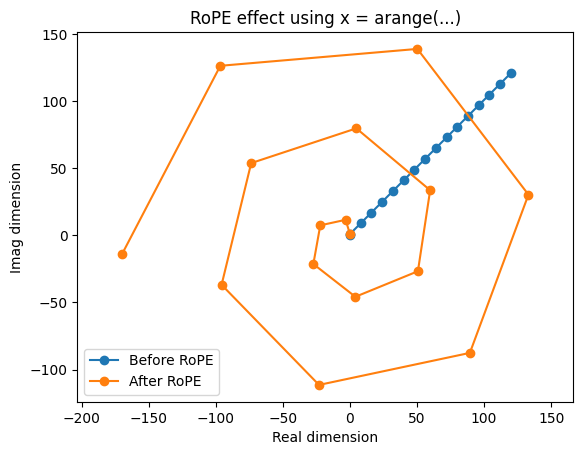

In [50]:
pair = 0  # visualize dims (0,1)

print(f"[PLOT] Visualizing complex pair {pair} -> dims ({2*pair}, {2*pair+1})")

# Extract (real, imag) before RoPE
x_pair = x_vis[0, :, 0, 2*pair:2*pair+2]
x_real, x_imag = x_pair[:, 0], x_pair[:, 1]

# Extract (real, imag) after RoPE
y_pair = y_vis[0, :, 0, 2*pair:2*pair+2]
y_real, y_imag = y_pair[:, 0], y_pair[:, 1]

# Plot
plt.figure()
plt.plot(x_real, x_imag, marker='o', label='Before RoPE')
plt.plot(y_real, y_imag, marker='o', label='After RoPE')
plt.scatter([0], [0])
plt.axis("equal")
plt.xlabel("Real dimension")
plt.ylabel("Imag dimension")
plt.title("RoPE effect using x = arange(...)")
plt.legend()
plt.show()

the spiral shape is due to torch.arange(). 